In [118]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')

In [2]:
%config Completer.use_jedi = False
%matplotlib inline

In [90]:
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [64]:
dataset = np.load("data/dataset.npz")

input_x = dataset["x"]
input_y = dataset["y"]

In [107]:
indices = np.unique(np.concatenate((np.argwhere(input_y < -1)[:, 0], np.argwhere(input_y > 1)[:, 0])))

input_x = np.delete(input_x, indices, axis=0)
input_y = np.delete(input_y, indices, axis=0)

input_x = input_x[:, :793]

In [108]:
train_x, val_x, train_y, val_y = train_test_split(input_x, input_y, random_state=123, shuffle=True, test_size=0.2)

In [112]:
def build_model():
    inputs = tf.keras.Input(shape=(793, ))

    x = Dense(793, activation='tanh')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(396, activation='tanh')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(84, activation="tanh")(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [113]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 793)]             0         
                                                                 
 dense_54 (Dense)            (None, 793)               629642    
                                                                 
 dropout_34 (Dropout)        (None, 793)               0         
                                                                 
 dense_55 (Dense)            (None, 396)               314424    
                                                                 
 dropout_35 (Dropout)        (None, 396)               0         
                                                                 
 dense_56 (Dense)            (None, 84)                33348     
                                                                 
Total params: 977,414
Trainable params: 977,414
Non-traina

In [114]:
history = model.fit(
    train_x, train_y, 
    validation_data=(val_x, val_y), 
    shuffle=True, batch_size=128, epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
)

Epoch 1/50
489/489 [==============================] - 1s 2ms/step - loss: 0.3478 - val_loss: 0.1140
Epoch 2/50
489/489 [==============================] - 1s 2ms/step - loss: 0.2620 - val_loss: 0.0983
Epoch 3/50
489/489 [==============================] - 1s 3ms/step - loss: 0.1722 - val_loss: 0.0779
Epoch 4/50
489/489 [==============================] - 1s 3ms/step - loss: 0.1231 - val_loss: 0.0732
Epoch 5/50
489/489 [==============================] - 1s 2ms/step - loss: 0.0989 - val_loss: 0.0729
Epoch 6/50
489/489 [==============================] - 1s 3ms/step - loss: 0.0859 - val_loss: 0.0724
Epoch 7/50
489/489 [==============================] - 1s 3ms/step - loss: 0.0786 - val_loss: 0.0723
Epoch 8/50
489/489 [==============================] - 1s 3ms/step - loss: 0.0745 - val_loss: 0.0707
Epoch 9/50
489/489 [==============================] - 1s 2ms/step - loss: 0.0723 - val_loss: 0.0704
Epoch 10/50
489/489 [==============================] - 1s 2ms/step - loss: 0.0711 - val_loss: 0.0700

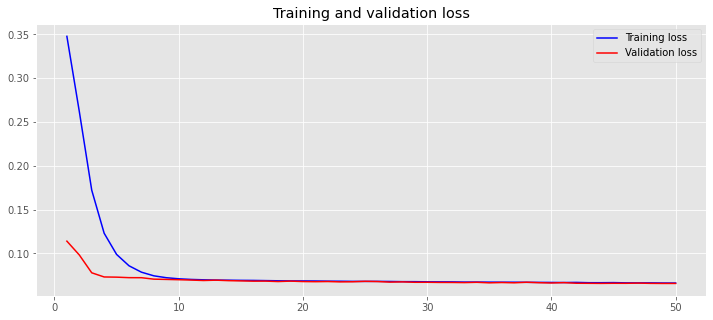

In [115]:
plot_history(history)

In [116]:
model.save("model_2.h5")

In [126]:
# Predictions

caption_files = glob.glob("data/captions/*.csv")

for caption_file in caption_files:
    
    video_id = caption_file.split("/")[-1].replace(".csv", "")
    text_feature_file = f"data/features/text/{video_id}.npy"

    captions = pd.read_csv(caption_file)
    
    output_folder = os.path.join("data/predictions", video_id)

    if not os.path.exists(output_folder): os.mkdir(output_folder)

    for i in range(len(captions)):
        t, d = captions.iloc[i, [0, 1]]

        audio_feature_file = f"data/features/audio/{video_id}/audio_feat_{t}_{d}.npy"

        if os.path.exists(audio_feature_file):
            audio_features = np.load(audio_feature_file)
            audio_features = audio_features.reshape(audio_features.shape[0], -1)
            
            predictions = model.predict(audio_features)
            
            output_file = f"data/predictions/{video_id}/handpose_{t}_{d}.npy"
            
            np.save(output_file, predictions)

In [127]:
!chown -R 1000:1000 data/predictions/*